# Laboratorium 08 — Self-supervised learning na zbiorze TissueMNIST

**Cel laboratorium:**
Poznanie i implementacja metody **Self-Supervised Learning (SimCLR - SIMple framework for Contrastive Learning of Representations)** do uczenia reprezentacji obrazów medycznych bez wykorzystania etykiet, a następnie zastosowanie nauczonych cech do zadania klasyfikacji wieloklasowej.

**Główne zagadnienia:**
- Czym jest Self-Supervised Learning (SSL) i dlaczego jest ważne w medycynie?
- Architektura SimCLR: encoder, projection head, contrastive loss (NT-Xent).
- Augmentacje danych dla contrastive learning.
- Pretrening modelu na danych nieoznaczonych.
- Ewaluacja jakości nauczonych reprezentacji.
- Porównanie z trenowaniem od zera (baseline).

**Struktura laboratorium:**
1. Pobranie i eksploracja danych TissueMNIST.
2. Implementacja datasetu i augmentacji dla SimCLR.
3. Budowa architektury: encoder z residual connections + projection head.
4. Pretrening SimCLR (self-supervised na pełnym zbiorze bez etykiet).
5. Trening klasyfikatora na małym zbiorze oznaczonym (downstream task):
   - Baseline: trening od zera.
   - SSL: zamrożony pretrenowany encoder + linear classifier.

**Dataset:**
**TissueMNIST** z MedMNIST - obrazy mikroskopowe tkanek nerkowych, 8 klas.

## 0. Wymagane pakiety

Przed rozpoczęciem pracy upewnij się, że masz zainstalowane wszystkie wymagane biblioteki. 
Jeśli pracujesz w Google Colab lub brakuje którejś biblioteki, odkomentuj i uruchom poniższą komórkę.

In [ ]:

# Odkomentuj w razie potrzeby (np. w Google Colab)
# !pip install -U pip
# !pip install torch torchvision torchaudio
# !pip install pytorch-lightning torchmetrics scikit-learn
# !pip install medmnist
# !pip install matplotlib pillow


## 1. Importy i ustawienia

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import Accuracy, AUROC

import medmnist
from medmnist import INFO

from lightly.loss import NTXentLoss
from pytorch_lightning.loggers import CSVLogger

import copy
import pandas as pd
from pytorch_lightning.loggers import TensorBoardLogger

print("Wersja PyTorch:", torch.__version__)
print("Wersja PyTorch Lightning:", pl.__version__)
print("Cuda dostępne:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Urządzenie:", device)

if torch.cuda.is_available():
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('medium')


Wersja PyTorch: 2.9.0+cu128
Wersja PyTorch Lightning: 2.5.5
Cuda dostępne: True
Urządzenie: cuda


/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## 2. Zbiór danych TissueMNIST (MedMNIST)

Opis zbioru:
Task: multi-class
Liczba klas: 8
Label: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
Liczność: train = 165466 val = 23640 test = 47280
Przykładowy obraz - shape: torch.Size([1, 64, 64])
Przykładowa etykieta (klasa): [0]


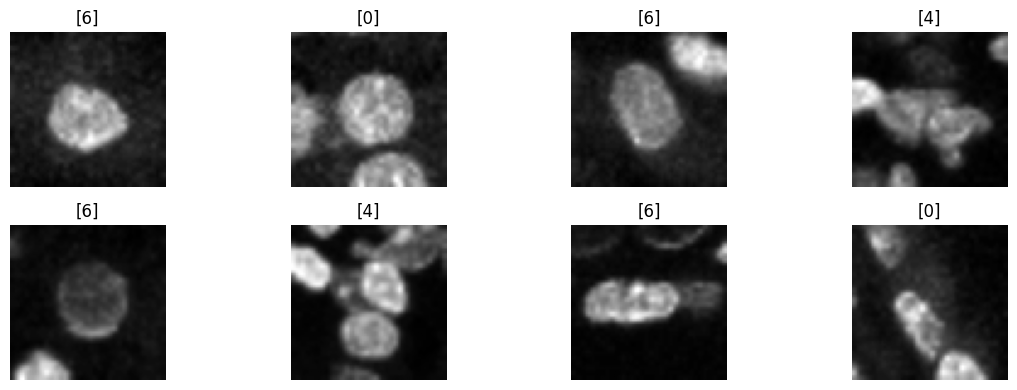

In [2]:
DATA_NAME = "TissueMNIST"
DATA_ROOT = "./data"
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO[DATA_NAME.lower()]
print("Opis zbioru:")
# print("Nazwa:", info['name'])
print("Task:", info['task'])
n_classes = len(info["label"])
print("Liczba klas:", n_classes)
print("Label:", info['label'])

num_labels = len(info['label'])

base_transform = transforms.Compose([
    transforms.ToTensor()
])

DataClass = getattr(medmnist, info["python_class"])

train_raw = DataClass(split='train', transform=base_transform, root=DATA_ROOT, download=True, size=64)
val_raw   = DataClass(split='val',   transform=base_transform, root=DATA_ROOT, download=True, size=64)
test_raw  = DataClass(split='test',  transform=base_transform, root=DATA_ROOT, download=True, size=64)

print("Liczność: train =", len(train_raw), "val =", len(val_raw), "test =", len(test_raw))

sample_img, sample_label = train_raw[0]
print("Przykładowy obraz - shape:", sample_img.shape)
print("Przykładowa etykieta (klasa):", sample_label)

def show_random_tissuemnist(dataset, n=8):
    idxs = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        img_np = img.squeeze().numpy()
        plt.subplot(2, n//2, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')
        plt.title(str(label))
    plt.tight_layout()
    plt.show()

show_random_tissuemnist(train_raw, n=8)

## 3. Wprowadzenie do Self-Supervised Learning (SSL)

**Self-Supervised Learning** to podejście, w którym model uczy się użytecznych reprezentacji danych **bez potrzeby ręcznego etykietowania**. Zamiast etykiet klas, model uczy się rozwiązywać zadanie zastępcze, które zmusza go do wydobywania istotnych cech.

**Dlaczego SSL jest ważne w obrazowaniu medycznym?**
- Etykietowanie danych medycznych jest drogie i czasochłonne (wymaga ekspertów).
- Mamy często dużo danych nieoznaczonych, ale mało danych z etykietami.
- Pretrening na dużym zbiorze nieoznaczonym + doucznie na małym zbiorze oznaczonym = lepsze wyniki.

**SimCLR (Simple Framework for Contrastive Learning of Visual Representations):**
SimCLR to jedna z najpopularniejszych metod SSL, która wykorzystuje uczenie kontrastowe:

1. **Augmentacje**: Dla każdego obrazu tworzymy 2 różne zaugmentowane wersje (widoki).
2. **Enkoder**: Przepuszczamy oba widoki przez enkoder, otrzymując reprezentacje cech.
3. **Projection Head**: Dodatkowa mała sieć, która przekształca cechy do przestrzeni, w której obliczamy podobieństwo.
4. **Contrastive Loss (NT-Xent)**: Uczymy sieć, aby:
   - Dwa widoki tego samego obrazu miały podobne cechy,
   - Widoki różnych obrazów miały różne cechy.

**Proces:**
```
Obraz → [Aug1] → View1 → Encoder → Projection → z1
     ↘ [Aug2] → View2 → Encoder → Projection → z2

Loss = maximize similarity(z1, z2) + minimize similarity(z1, z_other)
```

**Po pretreningu:**
- Zachowujemy tylko enkoder (wyrzucamy projection head).
- Używamy go jako ekstraktora cech dla innych zadań (np. klasyfikacji).
- Trenujemy tylko head lub cały model (fine-tuning).

## Zadanie 1 - Dataset i DataModule dla SimCLR

W SimCLR potrzebujemy dla każdego obrazu dwóch zmodyfikowanych widoków tego samego przykładu.
Etykiety nie są używane w podczas tego treningu – model musi wiedzień tylko które pary obrazów pochodzą od tej samej próbki.

Zazwyczaj im silniejsze augmentacje, tym trudniejsze zadanie dla sieci, ale nauczone reprezentacje mogą być lepsze.

**Implementacja augmentacji:**

Utwórz klasę `SimCLRTransform`:
1. W konstruktorze:
  - Zapamiętaj argument `image_size`
  - Stwórz obiekt zawierający transformacje dla uczenia SimCLR. Wykorzystaj takie transformacje jak:
    - `transforms.ToPILImage()` – konwersja tensora do PIL Image
    - `transforms.RandomResizedCrop` – losowe przycięcie
    - `transforms.RandomHorizontalFlip` – odbicie w poziomie
    - `transforms.RandomVerticalFlip` – odbicie w pionie
    - `transforms.RandomRotation` – rotacja
    - `transforms.RandomApply` razem z `transforms.ColorJitter`
    - `transforms.RandomGrayscale` – konwersja do skali szarości
    - `transforms.GaussianBlur` – rozmycie gaussowskie
    - `transforms.RandomAffine` – losowe przesunięcie
    - `transforms.ToTensor()` – konwersja do tensora
    - `transforms.Normalize(mean=[0.5], std=[0.5])` – normalizacja do [-1, 1]
2. W metodzie `__call__(self, x)`:
  - Zastosuj augmentację do `x` i zapisz jako `v1`
  - Zastosuj augmentację do `x` i zapisz jako `v2`
  - Zwróć oba zmodyfikowane obrazy

**Implementacja Dataset:**

Utwórz klasę `SimCLRDataset` dziedziczącą po `Dataset`:
1. W konstruktorze:
  - Zapamiętaj przekazany dataset
  - Zapamiętaj przekazany obiekt transformacji
2. W metodzie `__len__(self)`:
  - Zwróć `len(self.ds)`
3. W metodzie `__getitem__(self, idx)`:
  - Pobierz obraz i etykietę o indekcie `idx` z zapamiętanego datasetu (etykieta może zostać zignorowana)
  - Zastosuj transformację, aby otrzymać dwa obrazy
  - Zwróć te obrazy

**Implementacja DataModule:**

Utwórz klasę `SimCLRDataModule` dziedziczącą po `pl.LightningDataModule`:
1. W konstruktorze: `__init__(self, train_medmnist, batch_size=256, num_workers=16)`:
  - Wywołaj `super().__init__()`
  - Zapamiętaj argumenty: dataset, rozmiar batcha i liczbę workerów
  - Stwórz instancję stworzonej klasy augmentacji
2. W metodzie `setup(self, stage=None)`:
  - Stwórz obiekt `self.train_dataset` klasy `SimCLRDataset` oraz przekaż odpowiednie argumenty
3. W metodzie `train_dataloader(self)`:
  - Zwróć `DataLoader` z następującymi parametrami:
    - `self.train_dataset`
    - `batch_size=self.batch_size`
    - `shuffle=True`
    - `num_workers=self.num_workers`
    - `pin_memory=True`
    - `drop_last=True` (ważne dla naszej funkcji straty!)

**Test**

1. Stwórz instancję klasy: `ssl_dm = ChestSimCLRDataModule(train_raw, batch_size=256)`.
2. Wywołaj metodę `setup`.
3. Pobierz pierwszy batch: `v1, v2 = next(iter(ssl_dm.train_dataloader()))`.
4. Wyświetl kształty: `print("Batch SimCLR shapes:", v1.shape, v2.shape)` (powinno być np. torch.Size([256, 1, 64, 64]) dla obu).

In [3]:
class SimCLRTransform:
    def __init__(self, image_size=64):
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),

            transforms.RandomApply([
                transforms.ColorJitter(
                    brightness=0.4, 
                    contrast=0.4, 
                    saturation=0.4, 
                    hue=0.1
                )
            ], p=0.8),

            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __call__(self, x):
        v1 = self.transform(x)
        v2 = self.transform(x)
        return v1, v2

In [4]:
class SimCLRDataset(Dataset):
    def __init__(self, dataset, transform):
        self.ds = dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, _ = self.ds[idx]
        v1, v2 = self.transform(img)
        return v1, v2

In [5]:
class SimCLRDataModule(pl.LightningDataModule):
    def __init__(self, train_medmnist, batch_size=256, num_workers=16):
        super().__init__()
        self.ds = train_medmnist
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = SimCLRTransform(image_size=64)

    def setup(self, stage=None):
        self.train_dataset = SimCLRDataset(self.ds, self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True
        )

In [6]:
ssl_dm = SimCLRDataModule(train_raw, batch_size=256)
ssl_dm.setup()

v1, v2 = next(iter(ssl_dm.train_dataloader()))
print("Batch SimCLR shapes:", v1.shape, v2.shape)

Batch SimCLR shapes: torch.Size([256, 1, 64, 64]) torch.Size([256, 1, 64, 64])


## Zadanie 2 - enkoder i projection head

Architektura SimCLR składa się z trzech dwóch komponentów:

**1. Enkoder (Encoder)**
- Sieć konwolucyjna ekstraktująca cechy z obrazów.
- Przekształca obraz (np. 64×64×1) w wektor cech (np. 256-wymiarowy).

**2. Projection Head**
- Mała sieć na końcu enkodera (zwykle 2-3 warstwy liniowe).
- Przekształca cechy z enkodera do przestrzeni, gdzie obliczamy podobieństwo.
- Po pretreningu wyrzucamy projection head i używamy tylko enkodera!
- Projection head specjalizuje się w contrastive task, ale enkoder uczy się ogólnych cech.

**Implementacja ResidualBlock:**

1. Utwórz klasę `ResidualBlock` dziedziczącą po `nn.Module`:
   - Argumentami konstruktora jest liczba cech na wejściu, liczba cech na wyjściu i stride:
     - Wywołaj `super().__init__()`
     - Stwórz pierwszą warstwę konwolucyjną o zadanej liczbie cech na wejściu i wyjściu, rozmiarze 3, zadanym stride i padding 1
     - Stwórz pierwszą warstwę `nn.BatchNorm2d` o liczbie kanałów wyjściowych
     - Stwórz drugą wartswę konwolucyjną, liczba kanałów wejściowych i wyjściowych jest równa liczbie cech na wyjściu modułu, rozmiar 3, stride 1, padding 1
     - Stwórz drugą warstwę `nn.BatchNorm2d` o liczbie kanałów wyjściowych
     - Stwórz warstwę konwolucyjną dla skip connection o zadanej liczbie cech na wejściu i wyjściu, rozmiarze 1 i zadanym stride
     - Stwórz warstwę `nn.BatchNorm2d` dla skip connection o liczbie kanałów wyjściowych
   - W metodzie `forward(self, x)`:
     - Przepuść wejście przez pierwszą konwolucję, pierwszy `nn.BatchNorm2d` i `F.relu`
     - Przepuść dane przez drugą konwolucję i drugi `nn.BatchNorm2d`
     - Do wyjścia dodaj skip connection, czyli wejście przepuszcone przez konwolucję i `nn.BatchNorm2d`
     - Sumę podaj na ReLU `F.relu`
     - Zwróć wynik

**Implementacja Encoder:**

1. Utwórz klasę `Encoder` dziedziczącą po `nn.Module`:
   - Argumentem konstruktora jest liczba cech na wyjściu enkodera:
     - Zapamiętaj liczbę cech na wyjściu
     - Wywołaj `super().__init__()`
     - Stwórz pierwszą warstwę konwolucyjną o liczbie kanałów wejściowcyh 1, wyjściowych 32, rozmiarze 3 i padding 1:
     - Stwórz pierwszą warstwę `nn.BatchNorm2d` o liczbie kanałów 32
     - Stwórz 4 `ResidualBlock`:
       - 32 -> 64, stride 2
       - 64 -> 128, stride 2
       - 128 -> 256, stride 2
       - 256 -> 512, stride 2
     - Stwórz warstwę adaptive pooling `nn.AdaptiveAvgPool2d` o rozmiarze wyjściowym `(1, 1)`
     - Stwórz warstwę liniową o 512 kanałach wejściowch i zadanej liczbie kanałów wyjściowych
     - Wywołaj `self._init_weights()` (już zaimplementowana)
   - W metodzie `forward(self, x)`:
     - Zastosuj pierwszą konwolucję, `nn.BatchNorm2d` i ReLU
     - Przepuść przez layer1, layer2, layer3, layer4
     - Zastosuj adaptive pooling
     - Spłaszcz: `x = torch.flatten(x, 1)`
     - Zastosuj fully connected
     - Zwróć wynik

**Implementacja ProjectionHead:**

1. Utwórz klasę `ProjectionHead` dziedziczącą po `nn.Module`:
   - Argumentami konstruktora są liczba kanałów na wejściu, liczba kanałów w warstwie ukrytej i liczba kanałów na wyjściu:
     - Wywołaj `super().__init__()`
     - Połącz kolejne warstwy używając `nn.Sequential`:
       - Warstwa w pełni połączona z liczby kanałów wejściowych do ukrytych,
       - `nn.BatchNorm1d`
       - `nn.ReLU(inplace=True)`
       - Warstwa w pełni połączona z liczby kanałów ukrytych do wyjściowych,
       - `nn.Linear(hidden_dim, proj_dim, bias=False)`
       - `nn.BatchNorm1d` (bez ReLU na końcu)
     - Wywołaj `self._init_weights()` (już zaimplementowana)
   - W metodzie `forward(self, x)` przepuść dane wejściowe przez utworzoną sieć
   - Zwróć wynik

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1,
            stride=stride, bias=False
        )
        self.skip_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        skip = self.skip_conv(x)
        skip = self.skip_bn(skip)

        out = out + skip
        out = F.relu(out)

        return out


In [8]:
class Encoder(nn.Module):
    """Encoder with residual connections and batch normalization for better gradient flow"""
    def __init__(self, out_dim=256):
        super().__init__()
        self.out_dim = out_dim

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, out_dim)

        self._init_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x
    
    def _init_weights(self): 
        for m in self.modules(): 
            if isinstance(m, nn.Conv2d): 
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
            elif isinstance(m, nn.BatchNorm2d): 
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 0) 
            elif isinstance(m, nn.Linear): 
                nn.init.normal_(m.weight, 0, 0.01) 
                nn.init.constant_(m.bias, 0)

In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=256, proj_dim=128):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, proj_dim, bias=False),
            nn.BatchNorm1d(proj_dim)
        )

        self._init_weights()

    def forward(self, x):
        return self.net(x)
    
    def _init_weights(self): 
        for m in self.modules(): 
            if isinstance(m, nn.Linear): 
                nn.init.normal_(m.weight, 0, 0.01) 
            elif isinstance(m, nn.BatchNorm1d): 
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 0)


## Zadanie 3 - Moduł SimCLR

Teraz chcemy połączyć zaimplementowane elementy w jeden finalny moduł do uczenia kontrastowego.

Wykorzystamy funkcję straty **NT-Xent Loss (Normalized Temperature-scaled Cross Entropy Loss)**

Funkcja straty dla uczenia kontrastywnego:
- Dla każdego obrazu mamy 2 widoki: (z1, z2).
- W batchu rozmiaru B mamy 2B widoków.
- Dla każdego z1 chcemy:
  - **Maksymalizować** podobieństwo do z2 (positive pair).
  - **Minimalizować** podobieństwo do wszystkich innych widoków (negative pairs).

**Parametr temperatury (T):**
- Kontroluje "ostrość" rozkładu podobieństw.
- Niższa temperatura (np. 0.07) → model musi być bardziej pewny podobieństwa.
- Wyższa temperatura (np. 0.5) → bardziej "miękkie" decyzje.

Matematycznie dla pary (i, j):
1. Wektory są normalizowane do długości (dzielone przez ich normę).
2. Podobieństwo dwóch wektorów definiowane jest jako ich iloczyn skalarny (czyli cosinus kąta pomiędzy nimi - im są bliżej, tym wartość zbliża się do 1).
3. Miara podobieństwa skalowana (dzielona) jest dodatkowo przez temperaturę. Im mniejszą ma wartość, tym większy nacisk jest kładziony na najlepsze podobieństwo.
4. Dla każdego widoku mamy 1 pozytywną parę i 2N-2 negatywnych widoków, gdzie N to rozmiar batcha.
5. Strata dla pojedynczej pary:

$$
\ell(i, j) = - \log \frac{\exp\left(\mathrm{sim}(z_i, z_j) / \tau\right)}{\sum_{k \neq i} \exp\left(\mathrm{sim}(z_i, z_k) / \tau\right)}
$$

Można to traktować jako cross-entropy między odpowiadającą parą a rozkładem softmax po wszystkich możliwych kandydatach.

6. Ostateczny wynik to średnia po stratach dla każdej próbki.
7. Wykorzystamy klasę `NTXentLoss` z biblioteki `lightly.loss` do obliczania tej straty.

**Implementacja SimCLRModule:**

1. Utwórz klasę `SimCLRModule` dziedziczącą po `LightningModule`:
   - Argumentami konstruktora są liczba kanałów na wyjściu enkodera, liczba kanałów na wyjściu z `ProjectionHead`, learning rate, temperatura (parametr funkcji straty) i maksymalna liczba epok:
     - Wywołaj `super().__init__()`
     - Zapisz hiperparametry: `self.save_hyperparameters()`
     - Stwórz enkoder (przekaż liczbę kanałów na wyjściu)
     - Stwórz projection head (przekaż liczby kanałów, w warstwie ukrytej możesz wykorzystać 256)
     - Stwórz obiekt do liczenia straty `self.ntxent = NTXentLoss(temperature=temperature)`
   
   - W metodzie `forward(self, x)`:
     - Przepuść wejście przez enkoder
     - Przepuść dane przez projection head
     - Zwróć wyjście z enkodera i projection head
   
   - W metodzie `training_step(self, batch, batch_idx)`:
     - Rozpakuj batch: `x1, x2 = batch`
     - Oblicz reprezentacje dla obu widoków (można zignorować wyjście z enkodera)
     - Oblicz stratę (wywołaj stworzony obiekt, jako argumenty podając wyjścia z projection head)
     - Zaloguj stratę: `self.log("train_ssl_loss", loss, on_step=False, on_epoch=True, prog_bar=True)`
     - Zwróć obliczoną stratę
   
   - W metodzie `configure_optimizers(self)`:
     - Stwórz optimizer: `optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)`
     - Stwórz scheduler: `scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=1e-6)`
     - Zwróć słownik:
       ```python
       {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "interval": "epoch",
           }
       }
       ```

In [10]:
class SimCLRModule(pl.LightningModule):
    def __init__(
        self,
        encoder_out_dim=256,
        proj_out_dim=128,
        lr=1e-3,
        temperature=0.5,
        max_epochs=100
    ):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = Encoder(out_dim=encoder_out_dim)

        self.projection_head = ProjectionHead(
            in_dim=encoder_out_dim,
            hidden_dim=256,
            proj_dim=proj_out_dim
        )

        self.ntxent = NTXentLoss(temperature=temperature)

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z

    def training_step(self, batch, batch_idx):
        x1, x2 = batch

        _, z1 = self.forward(x1)
        _, z2 = self.forward(x2)

        loss = self.ntxent(z1, z2)

        self.log(
            "train_ssl_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True
        )

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
            }
        }

## Zadanie 4 - Trening SimCLR

Teraz przechodzimy do właściwego pretreningu SimCLR.

**Konfiguracja i trening SimCLR:**

1. Stwórz DataModule (zaimplementowany w zadaniu 1):
   - Charakterystycznym elementem metody SimCLR jest duży rozmiar batcha. Chcemy wykorzystać 1024, a mniejszy rozmiar tylko w przypadku ograniczenia pamięci GPU.
   - W przypadku braku wystarczającej pamięci GPU można wykorzystać mniejszy rozmiar batcha, a zamiast tego zasymulować większy batch przez akumulację gradientów dla kilku kolejnych batchy za pomocą argumentu `accumulate_grad_batches` metody `.fit`.
   - Liczba workerów też jest bardzo ważna z uwagi na rozmiar batcha i wiele augmentacji do wykonania.
   - Wywołaj metodę `setup()`

2. Stwórz sieć SimCLR (z poprzedniego zadania):
   - Aby uczenie kontrastowe było efektywne wymaga również długiego procesu uczenia. Dobrze jest uczyć nawet przez 40 epok.
   - Domyślne parametry: rozmiar wyjścia enkodera 256, rozmiar wyjścia projection head 128, learning rate 3e-4, temperatura 0.07.
   - Możesz spróbować innych parametrów w swojej implementacji.

3. Callback do zapisywania najlepszego modelu oraz obiekt do logowania danych są już stworzone w kodzie.

4. Stwórz Trainer:
   - Podaj argumenty `max_epochs`, `callbacks` jako `[checkpoint_simclr]`, `logger` jako `csv_logger_ssl`, `log_every_n_steps` równe 10. Dodatkowo wykorzystamy `gradient_clip_val=1.0` w celu poprawy stabilności treningu.

5. Rozpocznij trening wywołując metodę `.fit` dla stworzonego trainera. Przekaż mu uczony model i DataModule. Trening z wykorzystaniem uczenia nienadzorowanego może być czasochłonny.

In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# -------------------------------------------------------
# 1. DataModule
# -------------------------------------------------------

batch_size = 1024
num_workers = 8

dm = SimCLRDataModule(
    train_raw,
    batch_size=batch_size,
    num_workers=num_workers,
)

dm.setup()


# -------------------------------------------------------
# 2. Stworzenie modelu SimCLR
# -------------------------------------------------------

model = SimCLRModule(
    encoder_out_dim=256,
    proj_out_dim=128,
    lr=3e-4,
    temperature=0.07,
    max_epochs=40,
)


# -------------------------------------------------------
# 3. Callback + logger (jeśli nie były wcześniej stworzone)
# -------------------------------------------------------

checkpoint_simclr = ModelCheckpoint(
    monitor="train_ssl_loss",
    mode="min",
    save_top_k=1,
    filename="simclr-{epoch:02d}-{train_ssl_loss:.3f}",
)

# Ensure metrics are saved to CSV for easy plotting
csv_logger_ssl = CSVLogger(save_dir="lightning_logs", name="simclr")


# -------------------------------------------------------
# 4. Stworzenie trenera
# -------------------------------------------------------

trainer = Trainer(
    max_epochs=40,
    callbacks=[checkpoint_simclr],
    logger=csv_logger_ssl,
    log_every_n_steps=10,
    gradient_clip_val=1.0,
    accumulate_grad_batches=1,   # zmień np. na 8 jeśli batch_size musisz zmniejszyć
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
# -------------------------------------------------------
# 5. Uruchomienie treningu
# -------------------------------------------------------

trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | encoder         | Encoder        | 5.0 M  | train
1 | projection_head | ProjectionHead | 99.1 K | train
2 | ntxent          | NTXentLoss     | 0      | train
-----------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.443    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 161/161 [01:42<00:00,  1.57it/s, v_num=2, train_ssl_loss=0.215]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 161/161 [01:42<00:00,  1.57it/s, v_num=2, train_ssl_loss=0.215]


## Zadanie 5 - Wizualizacja treningu SimCLR

Po zakończeniu treningu warto przeanalizować krzywą uczenia, aby sprawdzić czy:
- Loss malał stabilnie (dobry znak).
- Nie ma gwałtownych skoków (oznaczałyby niestabilność).
- Osiągnęliśmy wypłaszczenie.

Wyniki
- Loss < 2.0 → ~dobre reprezentacje.
- Loss > 3.0 → model może nie nauczyć się użytecznych cech.
- Gładka krzywa → stabilny trening.

Poniższy fragment kodu (już zaimplementowany) wyświetla stratę po kolejnych epokach treningu.

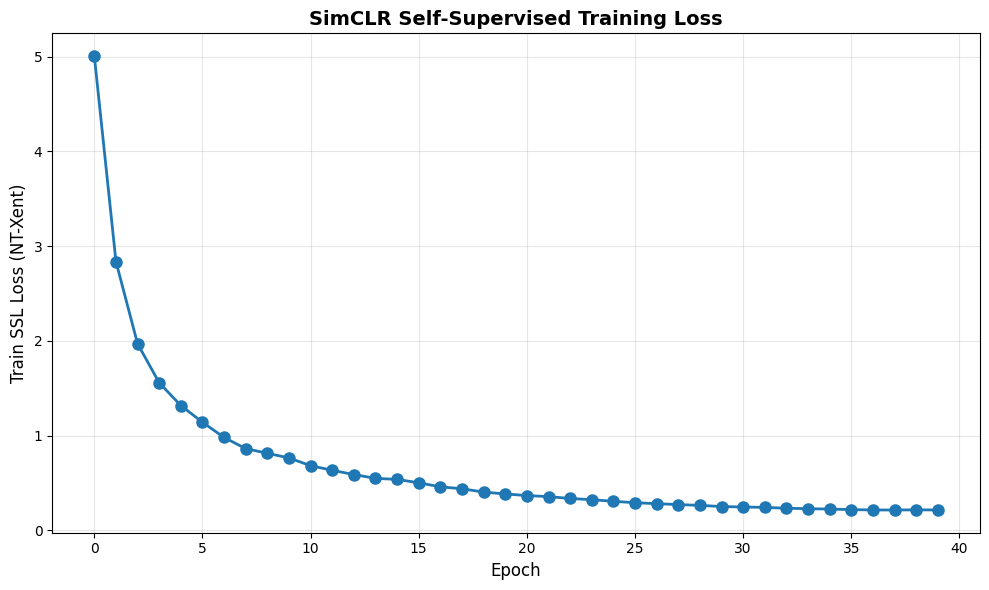

Final training loss: 0.2151
Best training loss: 0.2147


In [13]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

train_loss = metrics[['epoch', 'train_ssl_loss']].dropna()

plt.figure(figsize=(10, 6))
plt.plot(train_loss['epoch'], train_loss['train_ssl_loss'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Train SSL Loss (NT-Xent)', fontsize=12)
plt.title('SimCLR Self-Supervised Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training loss: {train_loss['train_ssl_loss'].iloc[-1]:.4f}")
print(f"Best training loss: {train_loss['train_ssl_loss'].min():.4f}")

## Zadanie 6 - Dataset i DataModule do klasyfikacji

Teraz przechodzimy do właściwego zadania klasyfikacji.
Załóżmy, że mamy dostęp tylko do (np. 4-15% zbioru treningowego).
To symuluje rzeczywistą sytuację w medycynie, gdzie etykietowanie jest drogie, ale mamy dostęp do dużej ilości danych bez oznaczeń. Parametr ten będziemy nazywać `train_fraction`.

**Parametr train_fraction:**
- `train_fraction=0.04` → używamy tylko 4% danych treningowych.
- `train_fraction=0.15` → używamy 15% danych treningowych.

**Implementacja ClassificationDataModule:**

1. Utwórz klasę `ClassificationDataModule` dziedziczącą po `pl.LightningDataModule`:
   - Konstruktor przyjmuje zbiór treningowy, walidacyjny i testowy, rozmiar batcha, liczbę workerów i `train_fraction`:
     - Wywołaj `super().__init__()`
     - Zapisz wszystkie parametry jako atrybuty
     - Stwórz transformację treningową wykorzystując `transforms.Compose`:
       - `transforms.RandomHorizontalFlip()`
       - `transforms.RandomRotation(10)`
       - `transforms.ToTensor()`
       - `transforms.Normalize(mean=[0.5], std=[0.5])`
     - Stwórz transformację walidacyjną wykorzystując `transforms.Compose`:
       - `transforms.ToTensor()`
       - `transforms.Normalize(mean=[0.5], std=[0.5])`
     - Podane augmentacje są tylko przykładowymi. W tym przypadku mogą one być znacznie słabsze niż dla SimCLR.

   - W metodzie `setup(self, stage=None)`:
     - Stwórz target_transform: `label_transform = transforms.Lambda(lambda y: torch.tensor(y, dtype=torch.long).squeeze())`. Funkcja ta będzie wykorzystywana dla wszystkich pobieranych etykiet
     - Stwórz pełny zbiór treningowy: `full_train_ds = DataClass(split='train', download=True, root=DATA_ROOT, size=64, transform=..., target_transform=label_transform)`
     - Oblicz liczbę próbek do użycia w treningu `n_used`. W tym celu pomnóż liczbę próbek w zbiorze treningowym przez `self.train_fraction`
     - Stwórz mniejszy podzbiór treningowy: `self.train_ds = torch.utils.data.Subset(full_train_ds, list(range(n_used)))`
     - Stwórz pełne zbiory walidacyjne `self.val_ds` i testowe `self.test_ds`. Tych zbiorów nie chcemy dzielić
     - Wyświetl liczbę próbek w pełnym oraz wydzielonym zbiorze treningowym

   - W metodzie `train_dataloader(self)`:
     - Zwróć `DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)`

   - W metodzie `val_dataloader(self)`:
     - Zwróć `DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)`

   - W metodzie `test_dataloader(self)`:
     - Zwróć `DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)`

**Test:**

1. Stwórz instancję zaimplementowanej klasy
2. Wywołaj metodę `setup()`
3. Pobierz batch: `xb_s, yb_s = next(iter(clf_dm.train_dataloader()))`
4. Wyświetl kształty: `print('Batch:', xb_s.shape, yb_s.shape)`

In [17]:
from torch.utils.data import Subset

class ClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_fraction: float,
        batch_size: int,
        num_workers: int,
        data_root: str,
        dataset_class,
    ):
        super().__init__()
        self.train_fraction = train_fraction
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_root = data_root
        self.dataset_class = dataset_class

        # --- transformacje ---
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

        self.val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

    def setup(self, stage=None):

        # konwersja etykiety na tensor typu long
        label_transform = transforms.Lambda(
            lambda y: torch.tensor(y, dtype=torch.long).squeeze()
        )

        # --- pełny zbiór treningowy ---
        full_train_ds = self.dataset_class(
            split='train',
            download=True,
            root=self.data_root,
            size=64,
            transform=self.train_transform,
            target_transform=label_transform,
        )

        n_total = len(full_train_ds)
        n_used = int(n_total * self.train_fraction)

        # podzbiór o zmniejszonym rozmiarze
        self.train_ds = Subset(full_train_ds, list(range(n_used)))

        # walidacja
        self.val_ds = self.dataset_class(
            split='val',
            download=True,
            root=self.data_root,
            size=64,
            transform=self.val_transform,
            target_transform=label_transform,
        )

        # test
        self.test_ds = self.dataset_class(
            split='test',
            download=True,
            root=self.data_root,
            size=64,
            transform=self.val_transform,
            target_transform=label_transform,
        )

        print(f"Pełny train: {n_total}  |  Używany train_fraction: {self.train_fraction} → {n_used} próbek")

    # --- dataloadery ---
    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [21]:
clf_dm = ClassificationDataModule(
    train_fraction=0.10,
    batch_size=64,
    num_workers=4,
    data_root=DATA_ROOT,
    dataset_class=DataClass
)

clf_dm.setup()

xb_s, yb_s = next(iter(clf_dm.train_dataloader()))
print("Batch:", xb_s.shape, yb_s.shape)

Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek
Batch: torch.Size([64, 1, 64, 64]) torch.Size([64])


## Zadanie 7 - Klasyfikator wieloklasowy

Moduł klasyfikacyjny łączy stworzony wcześniej enkoder z warstwą liniową do predykcji klas.

**Implementacja ClassifierModule:**

1. Utwórz klasę `ClassifierModule` dziedziczącą po `LightningModule`:
   - Kontruktor przyjmuje liczbę klas, enkoder (chcemy mieć możliwość przekazania wcześniej wytrenowanego), learning rate i flagę zamrożenia enkodera.
     - Wywołaj `super().__init__()`
     - Zapisz hiperparametry: `self.save_hyperparameters(ignore=["encoder"])`
     - Jeśli nie przekazano enkodera:
       - Stwórz nowy: `self.encoder = Encoder(out_dim=256)` (rozmiar wyjścia chcemy przekazać taki sam jak w enkoderze dla SimCLR)
       - W przeciwnym razie użyj przekazanego: `self.encoder = encoder`
     - Jeśli `freeze_encoder == True`:
       - Zamroź parametry enkodera: `for p in self.encoder.parameters(): p.requires_grad = False`
     - Stwórz klasyfikator: `self.classifier = nn.Linear(self.encoder.out_dim, num_classes)`
     - Stwórz funkcję straty: `self.criterion = nn.CrossEntropyLoss()`
     - Stwórz metryki accuracy:
       ```python
       self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
       self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
       self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
       ```

   - W metodzie `forward(self, x)`:
     - Przepuść przez enkoder
     - Przepuść przez klasyfikator
     - Zwróć wynik

   - W metodach `training_step(self, batch, batch_idx)`, `validation_step(self, batch, batch_idx)` i `test_step(self, batch, batch_idx)`:
     - Rozpakuj batch: `x, y = batch`
     - Oblicz wyjście sieci: `logits = self(x)`
     - Oblicz stratę: `loss = self.criterion(logits, y)`
     - Oblicz softmax: `probs = F.softmax(logits, dim=1)`
     - Oblicz accuracy odpowiednim obiektem, np. `acc = self.train_acc(logits, y)`
     - Zaloguj stratę: `self.log("train_loss", loss, on_step=False, on_epoch=True)`
     - Zaloguj accuracy: `self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)`
     - Dla `"val"` i `"test"` analogicznie (używając odpowiednich metryk i nazw)
     - Zwróć `loss`

   - W metodzie `configure_optimizers(self)`:
     - Stwórz optimizer: `optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)`
     - Zwróć `optimizer`

In [22]:
class ClassifierModule(pl.LightningModule):
    def __init__(
        self,
        num_classes: int,
        encoder=None,
        lr: float = 1e-3,
        freeze_encoder: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder"])

        # --- encoder ---
        if encoder is None:
            self.encoder = Encoder(out_dim=256)
        else:
            self.encoder = encoder

        # opcjonalnie zamrażamy encoder
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # --- classifier ---
        self.classifier = nn.Linear(self.encoder.out_dim, num_classes)

        # --- loss ---
        self.criterion = nn.CrossEntropyLoss()

        # --- metrics ---
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

    # -------------------------
    # FORWARD
    # -------------------------
    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return logits

    # -------------------------
    # TRAINING
    # -------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.criterion(logits, y)
        probs = F.softmax(logits, dim=1)

        acc = self.train_acc(logits, y)

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    # -------------------------
    # VALIDATION
    # -------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.criterion(logits, y)
        probs = F.softmax(logits, dim=1)

        acc = self.val_acc(logits, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    # -------------------------
    # TEST
    # -------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.criterion(logits, y)
        probs = F.softmax(logits, dim=1)

        acc = self.test_acc(logits, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    # -------------------------
    # OPTIMIZER
    # -------------------------
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


## Zadanie 8 - trening klasyfikatora od zera

Teraz chcemy aprawdzić jak dobrze możemy nauczyć model klasyfikacji, gdy mamy tylko część oznaczonych danych treningowych i sieć nie ma wcześniejszej wiedzy.
Wynik będzie punktem odniesienia do porównania z SimCLR.

1. Poniżej stwórz `ClassificationDataModule` (przekaż jaką część danych wykorzystać do treningu - 4-15%) oraz `ClassifierModule` (bez przekazanego enkodera i zamrożonych wag).

2. Przeprowadź trening. W tym przypadku wystarczy znacznie mniej (<10) epok.

3. Oblicz skuteczność na zbiorze testowym: `trainer.test(model, datamodule.test_dataloader())`

In [23]:
model_scratch = ClassifierModule(
    num_classes=n_classes,
    encoder=None,
    lr=1e-3,
    freeze_encoder=False
)


In [24]:
trainer_scratch = pl.Trainer(
    max_epochs=8,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10
)

trainer_scratch.fit(model_scratch, clf_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
-------------------------------------

Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek
Epoch 7: 100%|██████████| 259/259 [00:06<00:00, 39.49it/s, v_num=0, val_loss=1.380, val_acc=0.476, train_acc=0.637]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 259/259 [00:06<00:00, 38.88it/s, v_num=0, val_loss=1.380, val_acc=0.476, train_acc=0.637]


In [25]:
test_results = trainer_scratch.test(model_scratch, clf_dm.test_dataloader())
print(test_results)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek
Testing DataLoader 0: 100%|██████████| 739/739 [00:03<00:00, 204.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4759940803050995     │
│         test_loss         │    1.3746458292007446     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3746458292007446, 'test_acc': 0.4759940803050995}]


## Zadanie 9 - Klasyfikator z enkoderem SimCLR

Teaz chcemy sprawdzić, czy pretrenowany enkoder SimCLR daje lepsze wyniki niż trening od zera: kopiujemy enkoder z wytrenowanego modelu SimCLR, zamrażamy jego parametry i uczymy tylko klasyfikator.

**Trening z pretrenowanym enkoderem:**

1. Na początku zróbmy głęboką kopię enkodera, żeby uniknąć przypadkowej modyfikacji jego parametrów:
   - `encoder_pretrained = copy.deepcopy(simclr.encoder)`

2. Następnie postępuj dokłądnie tak samo jak w przypadku treningu w poprzednim zadaniu, alr pamiętaj o przekazaniu skopiowanego enkodera i zamrożeniu jego wag.

3. Wykorzystaj taki sam `train_fraction` jak w poprzednim zadaniu.

In [27]:
import copy

encoder_pretrained = copy.deepcopy(model.encoder)

model_simclr = ClassifierModule(
    num_classes=n_classes,
    encoder=encoder_pretrained,
    lr=1e-3,
    freeze_encoder=True
)

In [29]:
clf_dm_simclr = ClassificationDataModule(
    train_fraction=0.10,
    batch_size=64,
    num_workers=4,
    data_root=DATA_ROOT,
    dataset_class=DataClass
)

clf_dm_simclr.setup()


Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek


In [30]:
trainer_simclr = pl.Trainer(
    max_epochs=8,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10
)

trainer_simclr.fit(model_simclr, clf_dm_simclr)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Encoder            | 5.0 M  | train
1 | classifier | Linear             | 2.1 K  | train
2 | criterion  | CrossEntropyLoss   | 0      | train
3 | train_acc  | MulticlassAccuracy | 0      | train
4 | val_acc    | MulticlassAccuracy | 0      | train
5 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
2.1 K     Trainable params
5.0 M     Non-trainable params
5.0 M     Total params
20.055    Total estimated model params size (MB)
38        Modules

Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek
Epoch 7: 100%|██████████| 259/259 [00:03<00:00, 80.53it/s, v_num=1, val_loss=1.170, val_acc=0.567, train_acc=0.568] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 259/259 [00:03<00:00, 78.95it/s, v_num=1, val_loss=1.170, val_acc=0.567, train_acc=0.568]


In [31]:
test_results_simclr = trainer_simclr.test(
    model_simclr, 
    clf_dm_simclr.test_dataloader()
)
print(test_results_simclr)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pełny train: 165466  |  Używany train_fraction: 0.1 → 16546 próbek
Testing DataLoader 0: 100%|██████████| 739/739 [00:04<00:00, 172.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.566835880279541     │
│         test_loss         │    1.1696797609329224     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1696797609329224, 'test_acc': 0.566835880279541}]


## Podsumowanie i wnioski

Odpowiedz krótko na poniższe pytania:

1. Który model osiągnął najlepsze wyniki na zbiorze testowym?
2. Kiedy warto używać SSL?
3. Jaką rolę pełnią augmentacje w SimCLR?